## To do
  * Spike triggered averaging

In [13]:
import numpy as np
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

WARMUP = 20
T_STEPS = 5
FRAME_SIZE = 20

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

Using cuda


In [2]:
class FramesDataset (torch.utils.data.Dataset):
    def __init__ (self, path, split_type):
        with open(path, 'rb') as file:
            dataset = pickle.load(file)

        n = len(dataset)
        splits = {
            "train": slice(0, int(n*0.8)),
            "val": slice(int(n*0.8), int(n*0.9)),
            "test": slice(int(n*0.9), None)
        }

        dataset = dataset[splits[split_type]]
        dataset = torch.from_numpy(np.array(dataset))
        dataset = dataset.type(torch.FloatTensor)
        
        self.dataset = dataset
        
    def __len__ (self):
        return len(self.dataset)
    
    def __getitem__ (self, i):
        window = self.dataset[i]
        x = window[:WARMUP, :]
        y = window[WARMUP:, :]

        return x, y

train_dataset = FramesDataset('./datasets/processed_dataset_small.pkl', 'train')
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)

print("Training dataset length:", len(train_dataset))

Training dataset length: 135000


In [11]:
class RNN_Network (nn.Module):
    def __init__ (self, hidden_units):
        super(RNN_Network, self).__init__()
        
        self.hidden_units = hidden_units
        
        self.rnn = nn.RNNCell(
            input_size = FRAME_SIZE**2,
            hidden_size = hidden_units,
            nonlinearity = 'relu'
        )     
        self.fc = nn.Linear(hidden_units, FRAME_SIZE**2)
        
        # Initialise RNN weights with identity matrix
        self.rnn.weight_hh = torch.nn.Parameter(torch.eye(hidden_units, hidden_units))
        
    def forward (self, inputs):
        predictions = []
        hidden_state = torch.zeros((inputs.shape[0], self.hidden_units)).to(DEVICE)
        
        # Warm up period
        for i in range(WARMUP):
            frame_batch = inputs[:, i, :]
            hidden_state = self.rnn(frame_batch, hidden_state)
        prediction = self.fc(hidden_state)
        predictions.append(prediction)

        # Autoregressive predictions
        for t in range(T_STEPS):
            hidden_state = self.rnn(prediction, hidden_state)
            prediction = self.fc(hidden_state)
            predictions.append(prediction)
            
        return torch.transpose(torch.stack(predictions), 0, 1)
    
    def save (self):
        file_name = './model-' + time.strftime('%Y%m%d-%H%M%S') + '.pt'
        torch.save(self.state_dict(), file_name)
        print('Saved model as ' + file_name)
    
    @staticmethod
    def load (hidden_units, path):
        model = RNN_Network(hidden_units)
        model.load_state_dict(torch.load(path))
        model.eval()

        return model.to(DEVICE)
    
def L1_regularisation (lam, loss, model):
    weights = torch.Tensor([]).to(DEVICE)
    for name, params in model.named_parameters():
        if name.endswith('weight'):
            weights = torch.cat((weights, params.flatten()), 0)
    
    return loss + lam*weights.abs().sum()

def plot_input_weights (model, hidden_units, title=""):
    weights = model.rnn.weight_ih.cpu().detach().numpy()    
    weights = np.reshape(weights[:hidden_units, :], (FRAME_SIZE, FRAME_SIZE*hidden_units))
    
    font_size = 5.5
    font_size_title = 6
    
    fig, ax = plt.subplots(dpi=200)
    ax.imshow(weights, extent=[0, hidden_units, 0, 1], cmap='gray')
    
    ax.set_xticks(np.arange(0, hidden_units+1))
    ax.set_xticklabels(np.arange(0, hidden_units+1), size=font_size)
    ax.set_xlabel('Hidden unit', size=font_size)
    
    ax.set_yticks(np.arange(0, 2))
    ax.set_yticklabels(np.arange(0, 2), size=font_size)    
    
    ax.grid(which='major', color='b', linestyle='-', linewidth=1)
    ax.set_title(title, size=font_size_title)

In [14]:
model = RNN_Network(hidden_units = 400)
model = model.to(DEVICE)

loss_history = []

n_epochs = 2
lr=3e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, n_epochs + 1):
    for batch_n, data in enumerate(train_data_loader):
        inputs, targets = data
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
        optimizer.zero_grad()
        output = model(inputs)
        loss = L1_regularisation(10e-6, criterion(output, targets), model)
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)  #Gradient Value Clipping
        optimizer.step()
        
        loss_history.append(loss)

    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Loss: {:.4f}".format(loss.item()))
    
model.save()

Epoch: 1/2............. Loss: 0.9470
Epoch: 2/2............. Loss: 0.8571


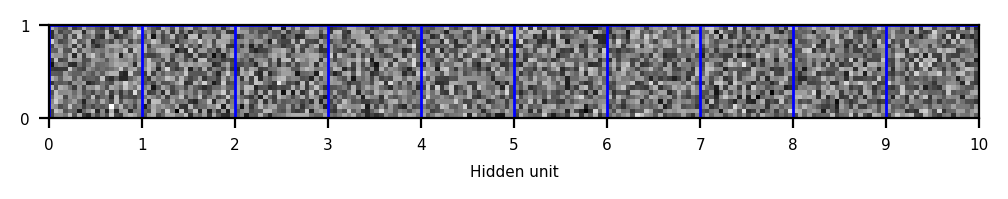

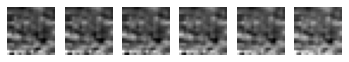

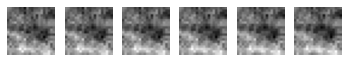

In [20]:
plot_input_weights(model, hidden_units = 10)

x, y = train_dataset[6]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred = torch.squeeze(model(torch.unsqueeze(x, 0)), 0)

fig, axes = plt.subplots(1, T_STEPS+1)
for i in range(T_STEPS+1):
    im_y = y[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, T_STEPS+1)
for i in range(T_STEPS+1):
    im_pred = pred[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
plt.show()